In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
%matplotlib inline

In [56]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = 3000

In [57]:
data_dict = load_SMD_dataset("./datasets/anomaly/SMD/SMD/processed", "machine-1-1", use_dim=2)

2020-11-30 15:43:58,182 P81049 INFO Loading machine-1-1 dataset


In [58]:
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
data_dict = pp.normalize(data_dict,method="standard")
# data_dict = pp.discretize(data_dict,n_bins=100)
# vocab_size = pp.build_vocab(data_dict)

window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2020-11-30 15:43:58,992 P81049 INFO Saving preprocessor into ./checkpoints/20201130-154357/preprocessor.pkl
2020-11-30 15:43:58,994 P81049 INFO Normalizing data
2020-11-30 15:43:59,000 P81049 INFO Generating sliding windows (size 128) for dataset [machine-1-1]
2020-11-30 15:43:59,141 P81049 INFO Saving hdf5 to ./datasets/anomaly/SMAP-MSL/hdf5/window_dict_ws=128_nrows=3000.hdf5


In [59]:
window_dict["train_windows"].shape

(2873, 1, 128)

In [60]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

In [61]:
encoder = MultiLSTMEncoder(vocab_size=None, embedding_dim=None, **params)

2020-11-30 15:44:02,503 P81049 INFO Compiling finished.


In [48]:
# batch_window = next(iter(train_iterator.loader))
# print(batch_window.shape)
# batch_window = batch_window.permute(0, 2, 1)  # b x win x ts_dim
# batch_window, y = batch_window[:, 0:-1, :], batch_window[:, -1, :]

In [62]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2020-11-30 15:44:03,719 P81049 INFO Start training for 2000 steps.
2020-11-30 15:44:03,722 P81049 INFO Epoch: 1
2020-11-30 15:44:20,127 P81049 INFO Epoch: 1, loss: 0.146
2020-11-30 15:44:20,132 P81049 INFO Saving model to ./checkpoints/20201130-154357/MultiLSTM_20201130-154357.pth
2020-11-30 15:44:20,137 P81049 INFO Epoch: 2
2020-11-30 15:44:37,056 P81049 INFO Epoch: 2, loss: 0.095
2020-11-30 15:44:37,061 P81049 INFO Saving model to ./checkpoints/20201130-154357/MultiLSTM_20201130-154357.pth
2020-11-30 15:44:37,064 P81049 INFO Epoch: 3
2020-11-30 15:44:53,168 P81049 INFO Epoch: 3, loss: 0.091
2020-11-30 15:44:53,173 P81049 INFO Saving model to ./checkpoints/20201130-154357/MultiLSTM_20201130-154357.pth
2020-11-30 15:44:53,176 P81049 INFO Epoch: 4
2020-11-30 15:45:08,692 P81049 INFO Epoch: 4, loss: 0.088
2020-11-30 15:45:08,697 P81049 INFO Saving model to ./checkpoints/20201130-154357/MultiLSTM_20201130-154357.pth
2020-11-30 15:45:08,700 P81049 INFO Epoch: 5
2020-11-30 15:45:26,403 P810

KeyboardInterrupt: 

In [63]:
encoder.load_encoder()

2020-11-30 15:47:25,472 P81049 INFO Loading model from ./checkpoints/20201130-154357/MultiLSTM_20201130-154357.pth


In [64]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader
encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["anomaly_label"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).cpu().numpy()
real_list = torch.cat(real_list).cpu().numpy()


0.0858276131666369


In [65]:
print(recst_list.shape)
print(real_list.shape)

(2873, 1)
(2873, 1)


In [66]:
print(recst_list[0:10, 0])
print(real_list[0:10, 0])

[-0.68710387 -0.691119   -0.695641   -0.69949853 -0.70254445 -0.7047853
 -0.7061235  -0.7072338  -0.7085686  -0.7104799 ]
[-0.97699046 -1.0657036  -0.9178305  -1.0361238  -1.0952835  -1.0952835
 -1.0952835  -1.1248635  -1.1544434  -1.1544434 ]


IndexError: index 1 is out of bounds for axis 1 with size 1

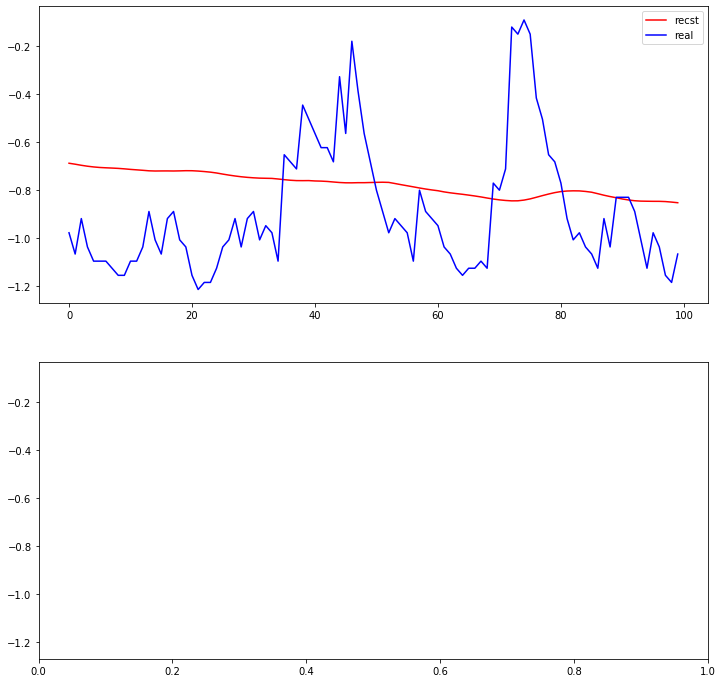

In [67]:
dims = [0,2]
fig, ax = plt.subplots(nrows=len(dims), sharey=True, figsize=(12,12))
for i in range(len(dims)):
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
    ax[i].plot(recst_list[0:100,i].reshape(-1), 'r', label='recst')
    ax[i].plot(real_list[0:100,i].reshape(-1), 'b', label='real')
    ax[i].legend(loc='best')

# ax[2].plot(recst, 'r', label='reconstruction')
# ax[2].plot(real, 'b', label='real')
# ax[2].legend(loc='best')

# ax[3].plot(diff, 'g', label='ecart')
# ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()